In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers import ZeroPadding2D, SeparableConv2D
from keras import backend as K
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD

import os
import cv2
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,confusion_matrix,classification_report

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
from tensorflow import set_random_seed

os.environ['PYTHONHASHSEED'] = "0"
np.random.seed(1)
set_random_seed(2)

In [3]:
train_data_dir = '/Users/coreycoole/Desktop/chest_xray/train'
validation_data_dir = '/Users/coreycoole/Desktop/chest_xray/val'
test_data_dir = '/Users/coreycoole/Desktop/chest_xray/test'

In [4]:
# dimensions of our images.
img_width, img_height = 150, 150

In [5]:
nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [6]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_width, img_height)
else:
    input_shape = (img_width, img_height, 1)

In [7]:
# this is the augmentation configuration we will use for training
gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [8]:
# this is the augmentation configuration we will use for testing:
# only rescaling
test_gen = ImageDataGenerator(rescale=1. / 255)

In [9]:
def cnn_model_sgd():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('sigmoid'))
    
    opt = SGD(lr=0.001, momentum=0.0, nesterov=False)
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    
    return model

In [11]:
model = cnn_model_sgd()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)       

In [12]:
train_batches = gen.flow_from_directory(train_data_dir,model.input_shape[1:3],
                                        color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)

valid_batches = gen.flow_from_directory(validation_data_dir, model.input_shape[1:3],
                                        color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)

test_batches = test_gen.flow_from_directory(test_data_dir, model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
filepath = 'cnn_sgd.best.weight.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                              monitor='val_loss', 
                              verbose=2, 
                              save_best_only=True, 
                              mode='min')
callbacks_list = [checkpoint]

In [14]:
model = cnn_model_sgd()

cnn_history = model.fit_generator(train_batches, class_weight={0:1.0, 1:0.4},
                                  steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=valid_batches,
                                  validation_steps=nb_validation_samples // batch_size, 
                                  callbacks=callbacks_list, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
326/326 [==============================] - 125s 382ms/step - loss: 0.3842 - acc: 0.5120 - val_loss: 0.6927 - val_acc: 0.5625

Epoch 00001: val_loss improved from inf to 0.69268, saving model to cnn_sgd.best.weight.hdf5
Epoch 2/20
326/326 [==============================] - 121s 372ms/step - loss: 0.3831 - acc: 0.6358 - val_loss: 0.6916 - val_acc: 0.5000

Epoch 00002: val_loss improved from 0.69268 to 0.69164, saving model to cnn_sgd.best.weight.hdf5
Epoch 3/20
326/326 [==============================] - 128s 392ms/step - loss: 0.3826 - acc: 0.7164 - val_loss: 0.6914 - val_acc: 0.5000

Epoch 00003: val_loss improved from 0.69164 to 0.69144, saving model to cnn_sgd.best.weight.hdf5
Epoch 4/20
326/326 [==============================] - 130s 399ms/step - loss: 0.3820 - acc: 0.7254 - val_loss: 0.6928 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 0.69144
Epoch 5/20
326/326 [==============================] - 121s 370ms/s

In [25]:
from keras.models import load_model

#model.save('final_capstone_sgd_opt_draft.h5')  # creates a HDF5 file 

# returns a compiled model
# identical to the previous one
#cnn_history = load_model('final_capstone_sgd_opt_draft.h5')

In [15]:
# evaluate the model

scores = model.evaluate_generator(test_batches)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))


acc: 84.86%


In [16]:
def plot_model(model_history, model_name):
    '''
    Simple function to plot the loss and accuracy of the validation data.
    '''
    sns.set_style("darkgrid")
    plt.style.use('tableau-colorblind10')
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,6))
    
    ax1.plot(model_history.history['acc'])
    ax1.plot(model_history.history['val_acc'])
    ax1.set_title(model_name + ' Model(Rmsprop) Accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')

    ax2.plot(model_history.history['loss'])
    ax2.plot(model_history.history['val_loss'])
    ax2.set_title(model_name + ' Model(Rmsprop) Loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

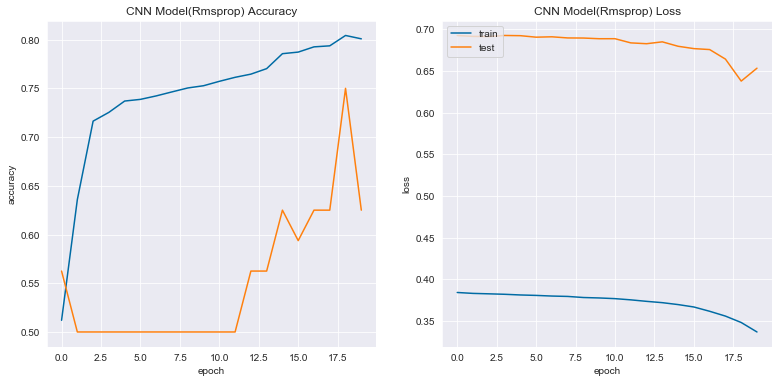

In [17]:
plot_model(cnn_history, 'CNN')
plt.savefig('sgd_draft_ACCURACY_LOSS.png')

In [19]:
p_sgd = model.predict(test_batches)
preds_sgd = np.argmax(p_sgd, axis=-1)
print(preds_sgd.shape)

(624,)


In [30]:
preds_sgd

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [31]:
test_loss_sgd, test_score_sgd = model.evaluate_generator(test_batches,steps=100)
print("Loss on test set: ", test_loss_sgd)
print("Accuracy on test set: ", test_score_sgd)

Loss on test set:  0.37891716465353964
Accuracy on test set:  0.83


In [20]:
CATEGORIES = ["NORMAL", "PNEUMONIA"]

def create_data(directory,data):
    for category in CATEGORIES:  # do normal and pneumonia

        path = os.path.join(directory,category)  # create path to normal and pneumonia
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=normal 1=pneumonia

        for img in tqdm(os.listdir(path)):  # iterate over each image per normal and pneumonia
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                
                data.append([img_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

In [21]:
test_data = []

create_data(test_data_dir,test_data)

print("Test Data Instances: {}".format(len(test_data)))

100%|██████████| 390/390 [00:01<00:00, 207.00it/s]

Test Data Instances: 624


In [22]:
y_test = []

for features,label in test_data:
    y_test.append(label)

In [37]:
recall_score(y_test,preds_sgd)

0.8179487179487179

In [38]:
print(classification_report(y_test, preds_sgd))

              precision    recall  f1-score   support

           0       0.74      0.84      0.78       234
           1       0.90      0.82      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.83      0.82       624
weighted avg       0.84      0.83      0.83       624



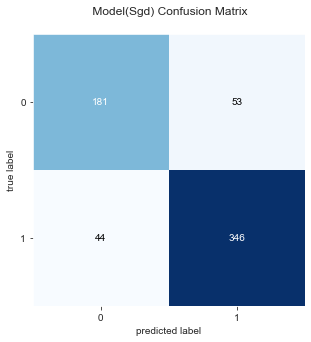

<Figure size 432x288 with 0 Axes>

In [23]:
CM = confusion_matrix(y_test, preds_sgd)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
ax.set_title(' Model(Sgd) Confusion Matrix')
plt.show()
plt.savefig('sgd_draft_CONFUSION_MATRIX.png')

In [24]:
from sklearn.metrics import roc_curve

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_test, preds_sgd)

In [25]:
from sklearn.metrics import auc
auc_sgd = auc(fpr_sgd, tpr_sgd)

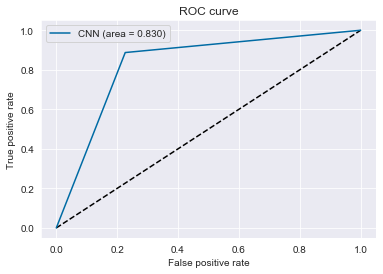

<Figure size 432x288 with 0 Axes>

In [26]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_sgd, tpr_sgd, label='CNN (area = {:.3f})'.format(auc_sgd))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.savefig('sgd_draft_ROC_CURVE.png')